In [20]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import re

In [21]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to C:\Users\Garuka
[nltk_data]     Ranjana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Garuka
[nltk_data]     Ranjana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Garuka
[nltk_data]     Ranjana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Garuka Ranjana\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [22]:
def preprocess_text(text):
    """Clean and preprocesess data by removing unwanted characters, tokenizing, removing stopwords, and lemmatizing."""
    if pd.isna(text):
        return ""
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'\S*@\S*\s?', '', text)  # Remove email addresses
    text = re.sub(r'[^a-zA-Z!?\']', ' ', text) # Remove special characters  
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    negative_words = {'no', 'not', 'never', "n't", 'neither', 'nor', 'none'}
    stop_words -= negative_words  # Retain negative words for sentiment analysis
    tokens = [lemmatizer.lemmatize(token)
              for token in tokens if token not in stop_words]
    return ' '.join(tokens)

In [23]:
def create_sentiment_labels(rating):
    """Convert numerical ratings into sentiment labels (positive, neutral, negative)."""
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

In [24]:
def prepare_data(df):
    """Prepare data by handling missing values, creating sentiment labels, and processing text."""
    df = df.dropna(subset=['reviewText'])  # Drop rows with missing review texts
    
    # Assume missing ratings as neutral
    df['overall'] = df['overall'].fillna(3)
    df['sentiment'] = df['overall'].apply(create_sentiment_labels)
    df['processed_text'] = df['reviewText'].apply(preprocess_text)
    return df

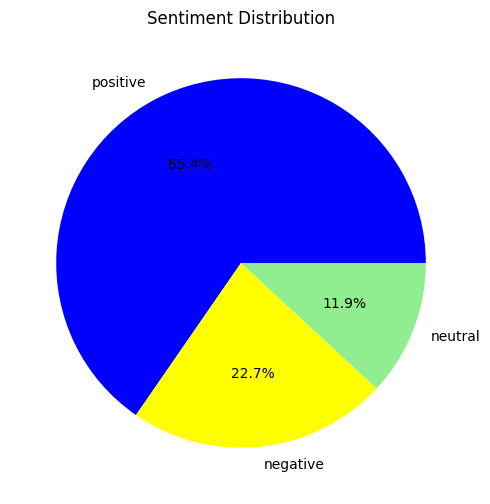

In [29]:
df['sentiment'] = df['overall'].apply(create_sentiment_labels)

# Sentiment distribution
plt.figure(figsize=(6, 6))
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                                    colors=['blue', 'yellow', 'lightgreen'])
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.show()

In [15]:
def train_model(df):
    """Train sentiment classification model using TF-IDF and Logistic Regression with SMOTE."""
    df = prepare_data(df)
    X = df['processed_text']
    y = df['sentiment']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)

    # Transform text data using TF-IDF
    tfidf = TfidfVectorizer(max_features=15000, ngram_range=(
        1, 3), min_df=2, max_df=0.9, sublinear_tf=True)
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    # Balance dataset using SMOTE to handle class imbalance
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(
        X_train_tfidf, y_train)

    # Define parameter grid for hyperparameter tuning
    param_grid = {
        'C': [0.01, 0.1, 1, 10]
    }

    # Train model using Logistic Regression with Grid Search
    clf = GridSearchCV(LogisticRegression(class_weight='balanced',
                       max_iter=200), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
    clf.fit(X_train_resampled, y_train_resampled)
    best_model = clf.best_estimator_

    # Make predictions on test data
    y_pred = best_model.predict(X_test_tfidf)

    # Print classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Create a pipeline for text preprocessing and classification
    pipeline = Pipeline([
        ('tfidf', tfidf),
        ('classifier', best_model)
    ])

    # Fit the pipeline on the full training data
    pipeline.fit(X_train, y_train)
    return pipeline, X_test, y_test, y_pred

In [ ]:
# Load dataset
df = pd.read_csv('dataset/amazon_reviews.csv')

# Train model
model, X_test, y_test, y_pred = train_model(df)

In [ ]:
# Confusion matrix visualization
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred, labels=[
                          'positive', 'neutral', 'negative'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[
                'positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(y_test, y_pred)

In [ ]:
def predict_sentiment(model, new_reviews):
    df_test = pd.DataFrame({'reviewText': new_reviews})
    df_test['processed_text'] = df_test['reviewText'].apply(preprocess_text)
    predictions = model.predict(df_test['processed_text'])

    for review, sentiment in zip(new_reviews, predictions):
        print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")

In [ ]:
# Define test reviews
test_reviews = [
    "This product is amazing! Works perfectly.",
    "really bad product not recommend.",
    "nothing special on this normal quality.",
    "Great quality but a bit expensive.",
    "Would recommend to anyone."
]

# Predict sentiment for test reviews
predict_sentiment(model, test_reviews)